# Analysing the frequencies of introgressed alleles in *D. sechellia* using IntroUNET

This notebook takes us through the steps of our analysis of the results from running IntroUNET on our *D. simulans* and *D. sechellia* data set. Before we start here, we have already run IntroUNET on these data to identify introgressed alleles (with the results in the .npz files that we read in in the third code block), and we also have the results from running FILET to call introgressed windows (the BED file in the second code block). The last bit of info we need is the input data to IntroUNET (the .npz files in the first code block immediately below), becuase these files also have the physical positions of the polymorphisms included in our analysis. Note that the paths to all of these files would be different if you were to run an IntroUNET analysis of your own, so treat these as placeholders.

First, read in our input alignment data, which we can use to extract the physical positions of each SNP (will need this later)

In [2]:
import numpy as np

posDat, positions = {}, {}
arms = ["2L", "2R", "3L", "3R", "X"]
for arm in arms:
    posDat[arm] = np.load(f'../realDataNpzs/simulans_sechellia_Scf_{arm}.phased.npz')
    print(arm)
    print(posDat[arm]['positions'].shape)
    print("")
    positions[arm] = posDat[arm]['positions']

2L
(1327413,)

2R
(1158818,)

3L
(1377765,)

3R
(1638830,)

X
(897656,)



Next, we read in the results from the original FILET analysis (can be found here: https://github.com/kr-colab/FILET/tree/master/simSechResults)
We build a table of all polymorphisms within the introgressed windows from the FILET paper (https://doi.org/10.1371/journal.pgen.1007341)
We will be looking at the frequencies of introgressed haplotypes within these windows.

In [3]:
filetResults = "/proj/dschridelab/drosophila/simSech/filetResults/intro_regions_sim_to_sech_clustered_flybase2.02.bed"

introgPositions = {}
introgBedWins = []
count = 0
with open(filetResults, 'rt') as f:
    for line in f:
        arm, s, e = line.strip().split()
        arm = arm.lstrip("chr")
        s, e = int(s), int(e)
        count += 1
        for pos in range(s+1, e+1):
            introgPositions[(arm, pos)] = 1
        introgBedWins.append((arm, s, e))

Now, we read in the aactual segmentation results from IntroUNET and print out some summary information. The `Y` key is used to store the predicted introgression probabilities for each `D. sechellia` individual at each SNP in the chromosome arm.

The and `x2i` key is used to specify which *D. sechellia* genome is shown at a given index of the `Y` array. We will need this information later to calculate frequencies, because some individuals appear twice in this array.

Note: This ordering only specifies the arrangement of individuals in our output `Y` array here, not the ordering of individuals in the actual input to IntroUNET, which varies across the genome because each window is seriated separately.

In [4]:
segDat = {}
for arm in arms:
    segDat[arm] = np.load(f'../seg_preds/{arm}.npz')
    print(list(segDat[arm].keys()))
    print(segDat[arm]['Y'].shape)
    print(segDat[arm]['x2i'])
    print("")

['Y', 'x1i', 'x2i']
(32, 1327413)
[20 21 22 23 24 25 26 27 28 29 30 31 32 33 20 23 30 32 25 28 28 30 28 30
 25 24 29 26 28 29 24 24]

['Y', 'x1i', 'x2i']
(32, 1158818)
[20 21 22 23 24 25 26 27 28 29 30 31 32 33 25 32 25 33 23 29 31 31 32 33
 29 28 31 20 29 22 23 20]

['Y', 'x1i', 'x2i']
(32, 1377765)
[20 21 22 23 24 25 26 27 28 29 30 31 32 33 31 30 26 25 21 27 26 22 29 28
 30 32 30 30 25 21 22 26]

['Y', 'x1i', 'x2i']
(32, 1638830)
[20 21 22 23 24 25 26 27 28 29 30 31 32 33 23 21 24 32 26 24 33 21 21 26
 25 32 24 27 28 28 29 28]

['Y', 'x1i', 'x2i']
(32, 897656)
[20 21 22 23 24 25 26 27 28 29 30 31 32 33 26 26 26 27 28 29 26 33 31 24
 33 32 29 29 23 26 27 28]



Next, we are going to calculate the introgression frequencies for each SNP within our introgressed windows. We define some helper functions for this below.

The first of these functions pulls out the indices of all IntroUNET predictions for a given individual. For most individuals there will be more than one, because we upsampled to bring our output up to the necessary size (32).

In the second function, we actually obtain our frequency estimate at a given site. This is done by averaging all of IntroUNET's predictions for a given individual at that site. Next, we use Platt recalibration to turn this prediction into a better estimate of the posterior probability that this allele was introgressed.

In [5]:
import math

def getSegIndicesForSamples(sampleMapping):
    sampleToIndices = {}
    offset = min(sampleMapping)
    for sampleIndex in range(offset, offset+len(set(sampleMapping))):
        sampleToIndices[sampleIndex] = []

    for i in range(len(sampleMapping)):
        sampleIndex = sampleMapping[i]
        sampleToIndices[sampleIndex].append(i)
    return sampleToIndices

def getIntrogFreqAtSite(segs, siteIndex, samples, sampleMapping, plattA=1.242379784584045410, plattB=-1.195908665657043457, thresh=0.95):
    segScores = 0
    for sample in samples:
        segScoreForSample = np.mean(segs[sampleMapping[sample], siteIndex])
        segScoreForSample = math.log((1 - segScoreForSample)/segScoreForSample)
        segScoreForSample = 1/(1 + math.exp(plattA*segScoreForSample + plattB))
        if segScoreForSample > thresh:
            segScores += 1
            introgAllelesInSample[arm][sample][siteIndex] = 1
    return segScores

Next, we calculate introgression frequencies at each polymorphism within the introgressed windows from FILET.

In [6]:
introgFreqs = {}
introgAllelesInSample = {}

for arm in arms:
    introgAllelesInSample[arm] = {}
    segs = segDat[arm]['Y'] #speeds things up
    segIndices = getSegIndicesForSamples(segDat[arm]['x2i'])
    
    samples = sorted(list(set(segDat[arm]['x2i'])))

    for sample in samples:
        introgAllelesInSample[arm][sample] = {}
    
    for snp in range(segDat[arm]['Y'].shape[1]):
        pos = positions[arm][snp]
        if (arm, pos) in introgPositions:
            introgFreq = getIntrogFreqAtSite(segs, snp, samples, segIndices)
            if introgFreq < len(samples)*0.5 and introgFreq > 0:
                introgFreqs[(arm, positions[arm][snp])] = introgFreq

Now, because we are going to be comparing the frequencies of introgressed haplotypes between different annotation categories, we are going to read in the annotations for the *D. simulans* genome.

In [7]:
gffPath = "/proj/dschridelab/drosophila/simulansFlyBaseRef/dsim-all-r2.02.gff.gz"
annotTypes = set(["gene", "mRNA", "intron", "exon", "three_prime_UTR", "five_prime_UTR", "CDS"])
            
import gzip

freqsForType = {}
for annotType in annotTypes:
    freqsForType[annotType] = {}

allAnnots = {}
with gzip.open(gffPath, 'rt') as f:
    for line in f:
        if not line.startswith("#"):
            if line.startswith(">"):
                break
            else:
                arm, source, annotType, s, e  = line.strip().split("\t")[:5]
                arm = arm.split("_")[1]
                if annotType in annotTypes:
                    s, e = int(s), int(e)
                    for pos in range(s, e+1):
                        if (arm, pos) in introgFreqs:
                            freqsForType[annotType][(arm, pos)] = introgFreqs[(arm, pos)]
                            allAnnots[(arm, pos)] = 1

Just for the heck of it, lets print out the number of SNPs and mean introgression frequency for each annotation type:

gene 47076 3.199974509304104
CDS 8279 3.290373233482305
five_prime_UTR 2340 3.414102564102564
mRNA 46578 3.1916999441796556
exon 13073 3.313547005278054
three_prime_UTR 1740 3.42816091954023
intron 36170 3.122449543820846
intergenic 19798 3.736943125568239
all 66874 3.358943685139217
gene
(array([0.23652817, 0.31789447, 0.1364517 , 0.16235024, 0.17175631,
       0.17501912]), array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
       5.16666667, 6.        ]))



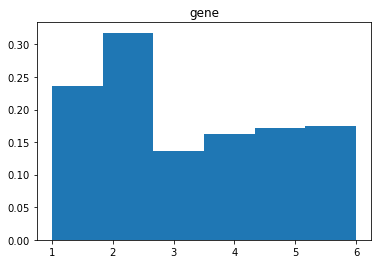

CDS
(array([0.18451504, 0.28191811, 0.23336152, 0.17552845, 0.15016306,
       0.17451383]), array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
       5.16666667, 6.        ]))



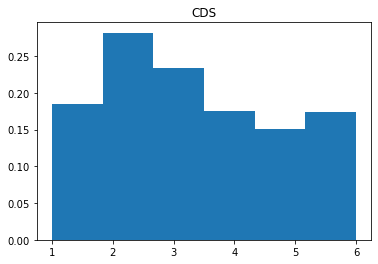

five_prime_UTR
(array([0.2374359 , 0.22051282, 0.11794872, 0.25128205, 0.1774359 ,
       0.19538462]), array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
       5.16666667, 6.        ]))



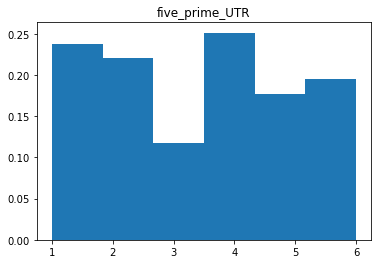

mRNA
(array([0.23771738, 0.32010821, 0.13561767, 0.16241144, 0.16926446,
       0.17488085]), array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
       5.16666667, 6.        ]))



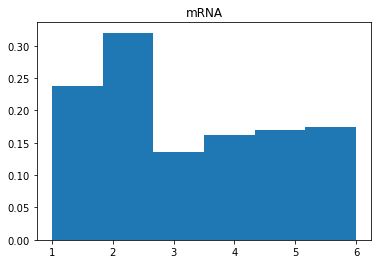

exon
(array([0.20515566, 0.265096  , 0.2035034 , 0.18184043, 0.16339019,
       0.1810143 ]), array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
       5.16666667, 6.        ]))



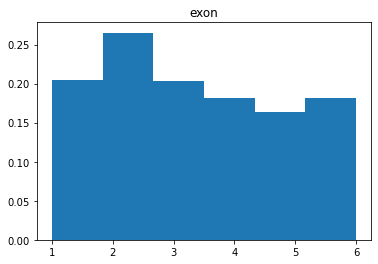

three_prime_UTR
(array([0.20344828, 0.24344828, 0.1937931 , 0.16068966, 0.19241379,
       0.2062069 ]), array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
       5.16666667, 6.        ]))



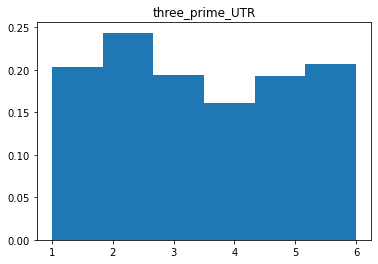

intron
(array([0.25612386, 0.34055847, 0.10954935, 0.15476915, 0.17202101,
       0.16697816]), array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
       5.16666667, 6.        ]))



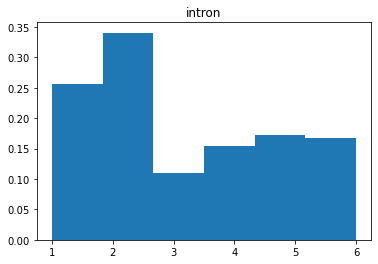

intergenic
(array([0.12510355, 0.23305384, 0.19674715, 0.19505001, 0.1775937 ,
       0.27245176]), array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
       5.16666667, 6.        ]))



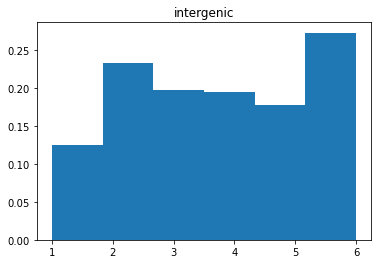

In [8]:
freqsForType["intergenic"] = {}   
for arm, pos in introgFreqs:
    if not (arm, pos) in allAnnots:
        freqsForType["intergenic"][(arm, pos)] = introgFreqs[(arm, pos)]
                            
for annotType in freqsForType:
    freqs = list(freqsForType[annotType].values())
    print(annotType, len(freqsForType[annotType]), np.mean(freqs))
    
allFreqs = [x for x in introgFreqs.values() if not np.isnan(x)]
print("all", len(allFreqs), np.mean(allFreqs))
maxFreq = max(allFreqs)

import matplotlib.pyplot as plt
for annotType in freqsForType:
    print(annotType)
    print(np.histogram([x for x in freqsForType[annotType].values() if not np.isnan(x)], bins=maxFreq, density=True))
    print("")
    
    fig = plt.figure()
    plt.hist([x for x in freqsForType[annotType].values() if not np.isnan(x)], bins=maxFreq, density=True)
    plt.title(annotType)
    plt.show()

But our focus here is on genic versus intregenic, so let's compare the two using a histogram. We will also a $\chi^2$ test to compare these two frequency distributions, but the p-value will be anticonservative because of LD.

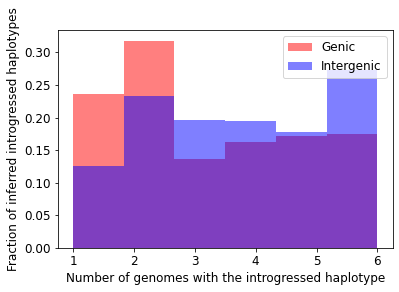

[9279, 12471, 5353, 6369, 6738, 6866]
[2064, 3845, 3246, 3218, 2930, 4495]
1882.880349506145 0.0


In [9]:
maxFreq = max(allFreqs)

plt.hist([x for x in freqsForType['gene'].values() if not np.isnan(x)], bins=maxFreq, density=True, alpha=0.5, label='Genic', color='red')
plt.hist([x for x in freqsForType['intergenic'].values() if not np.isnan(x)], bins=maxFreq, density=True, alpha=0.5, label='Intergenic', color='blue')
plt.xlabel("Number of genomes with the introgressed haplotype", fontsize=12)
plt.ylabel("Fraction of inferred introgressed haplotypes", fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

import scipy.stats
import collections
genicCounts = collections.Counter([x for x in freqsForType["gene"].values() if not np.isnan(x)])
intergenicCounts = collections.Counter([x for x in freqsForType["intergenic"].values() if not np.isnan(x)])
genicCounts = [genicCounts.get(x, 0) for x in range(1, maxFreq+1)]
print(genicCounts)
intergenicCounts = [intergenicCounts.get(x, 0) for x in range(1, maxFreq+1)]
print(intergenicCounts)
xsquare, pval, dof, exp = scipy.stats.chi2_contingency([genicCounts, intergenicCounts])
print(xsquare, pval)

Finally, we will compare frequencies inside and outside of the adaptive introgression region on 3R:

Sweep Region 3848 3.4547817047817047 0
Other 63026 3.353092374575572 0



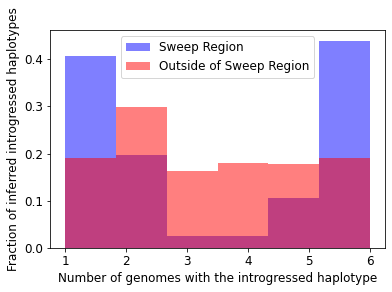

[1306, 631, 78, 82, 342, 1409]
[10037, 15685, 8521, 9505, 9326, 9952]
2611.2153375911435 0.0


In [10]:
freqsForSweepType = {"Sweep Region": {}, "Other": {}}                   
for arm, pos in introgFreqs:
    if arm == "3R" and pos <= 4769900 and pos > 4539900:
        freqsForSweepType["Sweep Region"][(arm, pos)] = introgFreqs[(arm, pos)]
    else:
        freqsForSweepType["Other"][(arm, pos)] = introgFreqs[(arm, pos)]

for annotType in freqsForSweepType:
    freqs = list(freqsForSweepType[annotType].values())
    print(annotType, len(freqsForSweepType[annotType]), np.nanmean(freqs), len([x for x in np.isnan(freqs) if x]))
print("")
         
plt.hist([x for x in freqsForSweepType['Sweep Region'].values() if not np.isnan(x)], bins=6, density=True, alpha=0.5, label='Sweep Region', color='blue')
plt.hist([x for x in freqsForSweepType['Other'].values() if not np.isnan(x)], bins=6, density=True, alpha=0.5, label='Outside of Sweep Region', color='red')
plt.xlabel("Number of genomes with the introgressed haplotype", fontsize=12)
plt.ylabel("Fraction of inferred introgressed haplotypes", fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

sweepCounts = collections.Counter([x for x in freqsForSweepType["Sweep Region"].values() if not np.isnan(x)])
otherCounts = collections.Counter([x for x in freqsForSweepType["Other"].values() if not np.isnan(x)])
maxFreq = max(allFreqs)
sweepCounts = [sweepCounts.get(x, 0) for x in range(1, maxFreq+1)]
print(sweepCounts)
otherCounts = [otherCounts.get(x, 0) for x in range(1, maxFreq+1)]
print(otherCounts)
xsquare, pval, dof, exp = scipy.stats.chi2_contingency([sweepCounts, otherCounts])
print(xsquare, pval)

## Getting introgressed haplotype lengths at increasing distances from the center of the sweep region

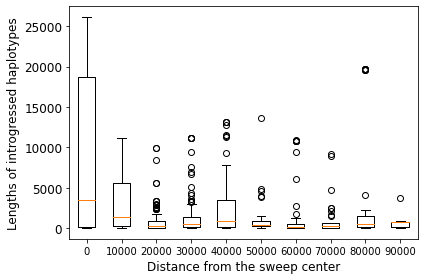

In [34]:
def getIntrogRuns(introgSnpIndices):
    indices = sorted(introgSnpIndices)
    runStart = indices[0]
    prevIndex = runStart
    runs = []
    
    for i in range(1, len(indices)):
        #print(i, indices[i], len(indices))
        if indices[i] == prevIndex + 1:
            prevIndex = indices[i]
        else:
            run = (positions[arm][runStart], positions[arm][prevIndex])
            runs.append(run)
            runStart = indices[i]
            prevIndex = runStart
    run = (positions[arm][runStart], positions[arm][prevIndex])
    runs.append(run)
    return runs
            

# this is the approximate location of the lowest-diversity region of the sweep
# (data from https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1007341)
sweepSite = 4624900
arm = '3R'

dists = list(range(0, 100000, 10000))
hapLensInDistBin = []
for dist in dists:
    hapLensInDistBin.append([])

for sample in samples:
    runs = getIntrogRuns(introgAllelesInSample[arm][sample])
    for s, e in runs:
        d = min([abs(sweepSite-s), abs(sweepSite-e)])
        if d < 1e5:
            runL = e-s+1
            
            distBin = int(d / 1e4)
            hapLensInDistBin[distBin].append(runL)


bplot = plt.boxplot(hapLensInDistBin, labels=dists)
plt.xlabel("Distance from the sweep center", fontsize=12)
plt.ylabel("Lengths of introgressed haplotypes", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)

for i in range(1, len(hapLensInDistBin)):
    sweepLens = hapLensInDistBin[0]
    currLens = hapLensInDistBin[i]

plt.tight_layout()
plt.savefig(f"introg_hap_lens_near_sweep.pdf")
plt.show()